In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import os

from src.data_models.positional.waypoint import Waypoint, Waypoints
from src.data_models.probability_map import ProbabilityMap
from src.waypoint_generation import WaypointFactory, WaypointAlgSettings
from src.enums import WaypointAlgorithmEnum

In [2]:
from src.waypoint_generation import CostFunc
cost_func = CostFunc()

wp_gen_settings = WaypointAlgSettings.Global()

2020-11-05 16:42:38.990 | DEBUG    | src.matlab_helper:__init__:43 - Starting <module 'matlab.engine' from '/home/jhewers/Documents/meng_project/code/venv/lib/python3.8/site-packages/matlab/engine/__init__.py'>
2020-11-05 16:42:42.713 | DEBUG    | src.matlab_helper:__init__:45 - <module 'matlab.engine' from '/home/jhewers/Documents/meng_project/code/venv/lib/python3.8/site-packages/matlab/engine/__init__.py'> instance at <matlab.engine.matlabengine.MatlabEngine object at 0x7f011483daf0>


In [3]:
with open("output.json", 'r') as f:
    data = json.loads(json.load(f))
    
img = np.array(data['img'])
del data['img']

for key in WaypointAlgorithmEnum:
    key = str(key)
    try:
        dat = data[key]
        wps = Waypoints(dat['wps'])        
        dat['wps'] = wps
        data[key].update(dat)
        print(f"{key} does exist ({len(wps)} wps)")
    except KeyError:
        print(f"{key} doesn't exist")

WaypointAlgorithmEnum.LHC_GW_CONV does exist (42 wps)
WaypointAlgorithmEnum.PARALLEL_SWATHS does exist (19 wps)
WaypointAlgorithmEnum.MODIFIED_LAWNMOWER does exist (21 wps)
WaypointAlgorithmEnum.PABO doesn't exist
WaypointAlgorithmEnum.PABO_FMINCON does exist (16 wps)
WaypointAlgorithmEnum.PABO_GA does exist (16 wps)
WaypointAlgorithmEnum.PABO_PARTICLESWARM does exist (16 wps)


WaypointAlgorithmEnum.LHC_GW_CONV
49.2843 units long
2.9790s


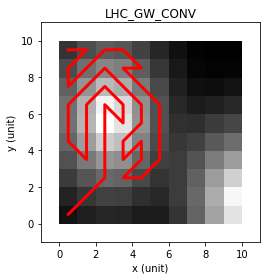

WaypointAlgorithmEnum.MODIFIED_LAWNMOWER
108.4142 units long
1.6073s


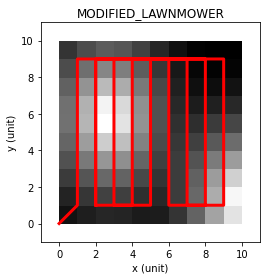

WaypointAlgorithmEnum.PARALLEL_SWATHS
81.4142 units long
0.0006s


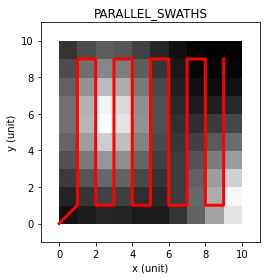

WaypointAlgorithmEnum.PABO_FMINCON
102.8707 units long
43.1208s


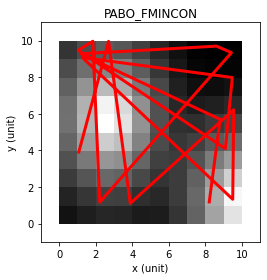

WaypointAlgorithmEnum.PABO_GA
98.6850 units long
509.3508s


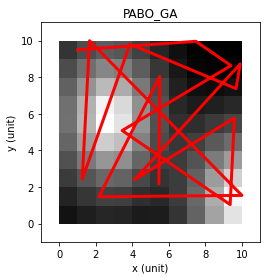

WaypointAlgorithmEnum.PABO_PARTICLESWARM
120.0583 units long
210.2586s


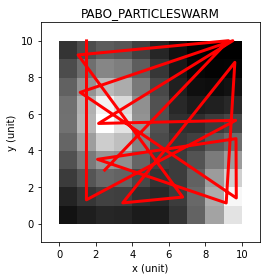

In [4]:
def plot(alg):
    fig, ax = plt.subplots()
    
    ax.imshow(img, interpolation=None,origin='bottom', extent=[0, img.shape[0], 0, img.shape[1]], cmap='gray')
    wps = data[str(alg)]['wps'].toNumpyArray()
    
    dist = np.sum(np.linalg.norm(wps[1:] - wps[:-1],axis=1))
    
    
    
    ax.plot(wps[:,0],wps[:,1],'r',linewidth=3)
        
    ax.set_xlim(-1,img.shape[0]+1)
    ax.set_ylim(-1,img.shape[1]+1)
    ax.set_xlabel("x (unit)")
    ax.set_ylabel("y (unit)")
    
    s = str(alg).split('.')[1]
    fig.savefig(s+"_path.png")
    ax.set_title(s)
    
    return fig,ax,dist
    
    
for key in data.keys():
    fig,ax,dist = plot(key)
    print(f"{key}\n{dist:.4f} units long\n{data[key]['time']:.4f}s")
    plt.tight_layout()
    plt.show()
    data[key]['dist'] = dist

In [5]:
def plot_bar(x,y,x_label,y_label):

    fig,ax = plt.subplots()
    plt.xticks(rotation=45)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.grid(True, linestyle='--', which='major',
                       color='grey', alpha=.25)
    ax.bar(x,y)   

    return fig,ax

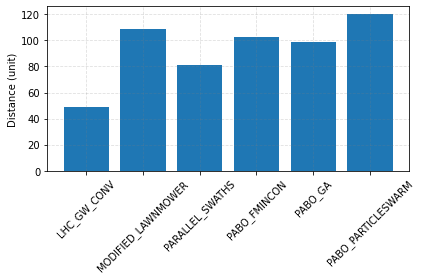

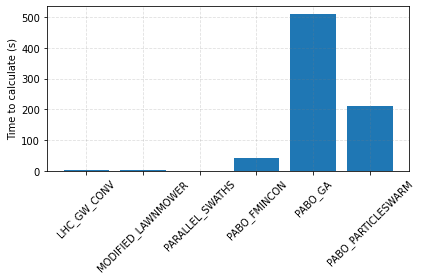

In [6]:
dists = [item[1]['dist'] for item in data.items()]
times = [item[1]['time'] for item in data.items()]

x = [str(s).split('.')[1] for s in data.keys()]

fig,ax=plot_bar(x,dists,"","Distance (unit)")
plt.tight_layout()
fig.savefig("unit_distances_all.png")

fig,ax=plot_bar(x,times,"","Time to calculate (s)")
plt.tight_layout()
fig.savefig("time_to_calculate_all.png")

In [7]:
# # Cost over time
# for key in data.keys():
#     d = data[key]
#     v = d['vehicle']
#     c_arr = []
#     wp_arr = []
#     t_arr = []
#     for x,y,t in zip(v['pos']['x'],v['pos']['y'],v['t']):
#         wp_arr.append(Waypoint(x,y))
#         wps = Waypoints(wp_arr)
#         cost = cost_func.calculate(wps,ProbabilityMap(img))
#         t_arr.append(t)
#         c_arr.append(cost)    
#     print(key)
#     plt.plot(t_arr,c_arr, label=key.split('.')[1].lower())


# plt.xlabel("Time (s)")
# plt.ylabel("Accumulated probability")
# plt.ylim([0, -1])
# plt.legend()
# plt.show()


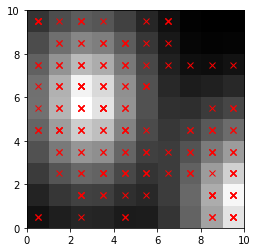

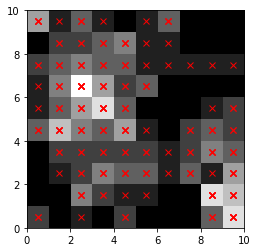

In [8]:
prob = ProbabilityMap(img)
points = prob.place(200)

x,y = np.meshgrid(np.arange(0,prob.shape[0]),np.arange(0,prob.shape[1]))
x,y = x.flatten(),y.flatten()
xy  = np.vstack((x,y)).T

img_placed = np.zeros(prob.shape)
unique, counts = np.unique([str(f) for f in points], return_counts=True)
unique = [(int(f),int(g)) for f,g in [h[1:-1].split(' ') for h in unique]]

for xyi, c in zip(unique,counts):
    x,y = xyi
    img_placed[x,y] = c


plt.imshow(prob, interpolation=None,origin='bottom', extent=[0, img.shape[0], 0, img.shape[1]], cmap='gray')
plt.plot(points[:,0]+0.5,points[:,1]+0.5,'rx')
plt.show()
plt.imshow(img_placed.T, interpolation=None,origin='bottom', extent=[0, img.shape[0], 0, img.shape[1]],cmap='gray')
plt.plot(points[:,0]+0.5,points[:,1]+0.5,'rx')
plt.show()





In [9]:
print(img[xy[9]])
print(prob.hq_prob_map[xy[9]])

[[0.00579272 0.00843722 0.0100743  0.00944465 0.00717794 0.00415565
  0.001763   0.00025186 0.         0.        ]
 [0.00201486 0.00327415 0.00415565 0.00402972 0.00302229 0.00314822
  0.00579272 0.01082987 0.01788188 0.02468203]]
[[0.00579272 0.00843722 0.0100743  0.00944465 0.00717794 0.00415565
  0.001763   0.00025186 0.         0.        ]
 [0.00201486 0.00327415 0.00415565 0.00402972 0.00302229 0.00314822
  0.00579272 0.01082987 0.01788188 0.02468203]]
